In [13]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio as disp_audio

In [140]:
SOUND_FILE = "my_eyes.wav"
IS_INSTRUMENTAL = False

# loads a song and returns data, rate
def load(songname: str, instr: bool = True, auto_ext: bool = True) -> tuple:
    return librosa.load(f"songs/{songname}{['', '_instr'][instr]}{['', '.wav'][auto_ext]}")

# displays a spectograph given stft song data
def disp_specto(s: np.ndarray) -> None:
    fig, ax = plt.subplots()
    img = librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(s), ref=np.max),
        y_axis='log', x_axis='time', ax=ax
    )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.show()

# displays the waveform 
def disp_wav(song: np.ndarray, rate: int, slice: slice) -> None:
    time = np.arange(len(song[slice]))/rate
    fig = plt.gcf()
    fig.set_size_inches(10, 2)
    plt.plot(time, song[slice], lw=1)
    plt.show()

# define functions
stft = librosa.stft
istft = librosa.istft

Make the file in `.wav` format

In [141]:
# check if in mp3 format
if (ext:=SOUND_FILE.split('.')[-1]) in ['mp3', 'flv', 'ogg', 'raw']:

    # convert to wav
    sound = eval(f"AudioSegment.from_{ext}(f'songs/{{SOUND_FILE}}')")
    os.system(f"rm songs/{SOUND_FILE}")
    SOUND_NAME = SOUND_FILE.removesuffix(f'.{ext}')
    sound.export(f"songs/{SOUND_NAME}.wav", format="wav")

else:
    
    # change to just the name of the file
    SOUND_NAME = SOUND_FILE.removesuffix('.wav')

Show segment

In [162]:
song, rate = load(SOUND_FILE, instr=False, auto_ext=False)

# determine slice for the rest of the thing 
SONG_SLICE = slice(190*rate, 200*rate)

disp_audio(data=song[SONG_SLICE], rate=rate)

Generate instrumental of the track

In [163]:
# credit to https://github.com/tsurumeso/vocal-remover
if not IS_INSTRUMENTAL and f"{SOUND_NAME}_instr.wav" not in os.listdir('songs'):
    _ = os.system(f"./sep_instr.sh {SOUND_NAME}")
song, rate = load(SOUND_NAME)
disp_audio(data=song[SONG_SLICE], rate=rate)

Display wavefile of slice

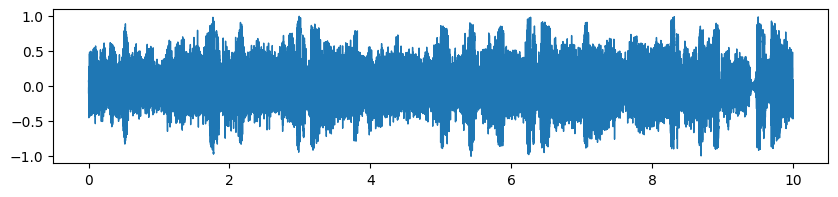

In [164]:
disp_wav(*load(SOUND_NAME), SONG_SLICE)

Display spectograph of slice

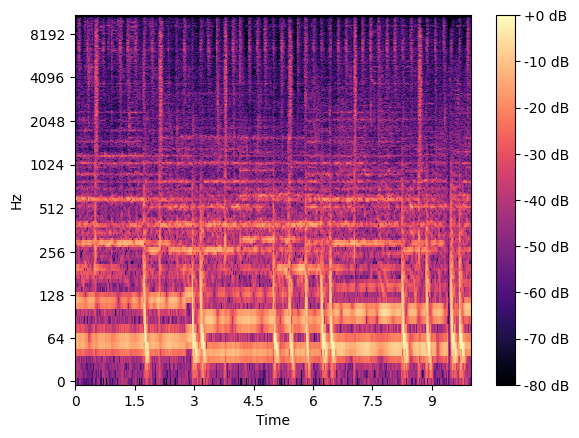

In [165]:
song, _ = load(SOUND_NAME)
s = stft(song[SONG_SLICE])
disp_specto(s)

Find absolute frequencies

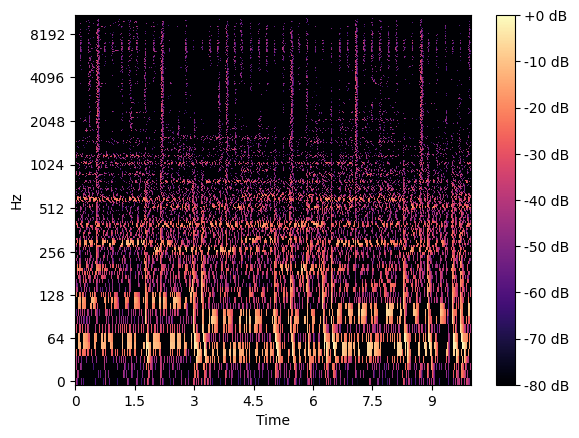

In [166]:
cap = np.vectorize(lambda x: max(0, x))

def sharpen_sounds(s: np.ndarray) -> np.ndarray:
    s = abs(s)
    new_s = np.zeros_like(s)
    for idx, freq_array in enumerate(s):
        shift_forward = np.array([0, *freq_array])
        shift_back = np.array([*freq_array, 0])
        diff: np.ndarray = cap(shift_forward - shift_back)
        mask = diff.astype(np.bool_).astype(np.uint8)
        new_s[idx] = mask[:-1] * freq_array
    return new_s

song, rate = load(SOUND_NAME)
s = sharpen_sounds(stft(song[SONG_SLICE]))
filtered_song = istft(s)
disp_specto(s)
disp_audio(data=filtered_song, rate=rate)

Filter frequencies too high or low

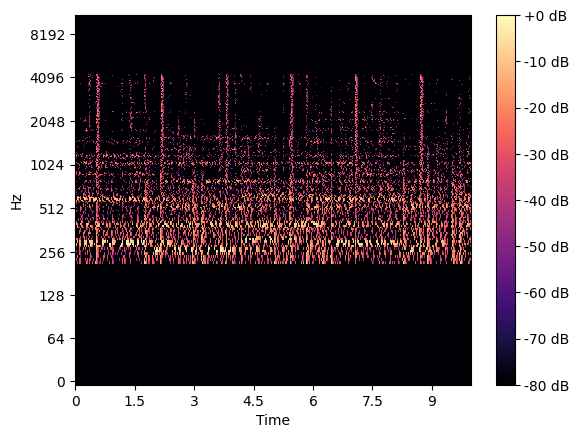

In [167]:
def filter_sounds(s: np.ndarray) -> np.ndarray:
    s[:20] = 0
    s[400:] = 0 
    return s

song, rate = load(SOUND_NAME)
s = filter_sounds(sharpen_sounds(stft(song[SONG_SLICE])))
filtered_song = istft(s)
disp_specto(s)
disp_audio(data=filtered_song, rate=rate)